# MARCH MADNESS Predictor
Authors: Connor Finn, Riley Greene <br>
Data: March 14, 2020

In [292]:
# we will be using the following packages
import pandas as pd
import numpy as np
import copy

# Read in our Data

In [293]:
season_stats = pd.read_csv("clean_data/season_stats.csv")
teams = pd.read_csv("clean_data/teams.csv")
ncaa_games = pd.read_csv("clean_data/ncaa_games.csv")
schools = pd.read_csv("clean_data/schools.csv")
tournament_stats = pd.read_csv("tournament_data/prelim_data.csv")


# Normalize the Data

We will do this with a z-score normalization

In [294]:
season_stats.iloc[: , 1:] = (season_stats.iloc[: , 1:] - season_stats.iloc[: , 1:].mean())/season_stats.iloc[: , 1:].std()
tournament_stats.iloc[: , 1:] = (tournament_stats.iloc[: , 1:] - tournament_stats.iloc[: , 1:].mean())/tournament_stats.iloc[: , 1:].std()

In [295]:
tournament_stats.head()

,Team,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,3P%,...,STL,BLK,TOV,PF,PTS/G,W-L%,SRS,SOS,opp_PPG,Seed
0,kansas,0.432825,-0.588745,1.339182,1.005115,0.353514,1.259721,-0.843544,-1.044838,-0.063699,...,0.867007,0.969694,0.223318,-1.440534,0.194986,1.776313,1.844086,1.071014,-1.280238,-1.614218
1,san-diego-state,0.447313,0.030428,0.676067,-0.403062,-0.817547,0.580593,1.368833,0.975948,1.270507,...,0.461612,-0.968631,-1.073720,0.199202,0.238017,2.125925,0.811453,-0.290021,-1.602501,-1.398989
2,maryland,-1.117377,-0.428958,-1.354723,-1.254157,-1.248498,-0.421928,0.094312,0.975948,-1.286721,...,-1.540026,0.595631,-0.924062,-1.256064,-0.407453,0.487741,0.723569,0.871278,-0.259740,-1.183760
3,kentucky,-0.378496,-0.938277,0.385954,0.788473,1.149836,-0.324910,-1.853542,-2.341599,-0.100760,...,-1.033282,1.241740,-0.001169,0.896090,0.151954,0.807387,0.403421,0.333934,0.169943,-0.968531
4,butler,-0.653765,-1.297797,0.344509,-0.356638,-0.714494,0.483575,-0.530925,-0.580165,-0.174883,...,-0.957271,-1.172665,-0.949005,-0.108248,-1.117469,-0.151551,0.368896,0.630887,-0.904265,-0.753302


# Build Feature Vector

In [296]:
# make a new dataframe:
data_matrix = ncaa_games.copy()

In [297]:
def build_feat_vec(r):
    """ 
    This function builds the feature vec by subtracting team_1's stats from team_2's stats
    """
    s1 = season_stats[season_stats["team_id"] == r["team_1_id"] ]
    s2 = season_stats[season_stats["team_id"] == r["team_2_id"] ]
    # reset the indices: this is important for subtraction
    s2 = s2.reset_index(drop=True)
    s1 = s1.reset_index(drop=True)   
    # subtract the two stat sets
    s3 = s1.sub(s2) 
    s3 = s3.iloc[0]
    # append the difference to the game information
    r = r.append(s3)
    # somehow return the information.
    return r
data_matrix = data_matrix.apply(build_feat_vec , axis = 1)

we can get rid of the team_id columns because of the game_id. 
we will use the scores to create a binary: 0 if team 1 loses, 1 if team 1 wins


In [298]:
# Build the result column
data_matrix["result"] = np.where(data_matrix['team_1_score'] > data_matrix['team_2_score'], 1, 0)

In [299]:
# remove unwanted columns
data_matrix = data_matrix.drop(["team_1_id" , "team_2_id" , "team_id" , "team_1_score" , "team_2_score"] , axis = 1)

# Feature Engineering

* Do we want to create any new variable?
* For now, lets simply reduce any overlap (i.e. FT = FTA * FT%)
    + We do not need all three

In [300]:
data_matrix = data_matrix.drop(["game_id" , "FT" , "2P" , "3P" , "FG" , "TRB"] , axis = 1)
tournament_stats = tournament_stats.drop([ "FT" , "2P" , "3P" , "FG" , "TRB"] , axis = 1)

In [301]:
tournament_stats.rename(columns = {'opp_PPG': 'PTS.1'})

,Team,FGA,FG%,2PA,2P%,3PA,3P%,FTA,FT%,ORB,...,STL,BLK,TOV,PF,PTS/G,W-L%,SRS,SOS,PTS.1,Seed
0,kansas,-0.588745,1.339182,0.353514,1.259721,-1.044838,-0.063699,0.123305,-1.333236,0.095964,...,0.867007,0.969694,0.223318,-1.440534,0.194986,1.776313,1.844086,1.071014,-1.280238,-1.614218
1,san-diego-state,0.030428,0.676067,-0.817547,0.580593,0.975948,1.270507,-0.928176,1.392200,-0.558180,...,0.461612,-0.968631,-1.073720,0.199202,0.238017,2.125925,0.811453,-0.290021,-1.602501,-1.398989
2,maryland,-0.428958,-1.354723,-1.248498,-0.421928,0.975948,-1.286721,0.697826,0.763253,0.368524,...,-1.540026,0.595631,-0.924062,-1.256064,-0.407453,0.487741,0.723569,0.871278,-0.259740,-1.183760
3,kentucky,-0.938277,0.385954,1.149836,-0.324910,-2.341599,-0.100760,1.066387,2.073559,-0.503668,...,-1.033282,1.241740,-0.001169,0.896090,0.151954,0.807387,0.403421,0.333934,0.169943,-0.968531
4,butler,-1.297797,0.344509,-0.714494,0.483575,-0.580165,-0.174883,-1.177497,0.265337,-0.867082,...,-0.957271,-1.172665,-0.949005,-0.108248,-1.117469,-0.151551,0.368896,0.630887,-0.904265,-0.753302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,stephen-f-austin,-0.109385,1.629295,1.590155,0.839308,-1.952571,0.603404,2.009468,-0.704290,1.422423,...,3.071343,-0.526557,4.064547,2.556324,1.485924,1.776313,-1.438997,-2.202541,0.411640,0.753302
60,cincinnati,-1.038144,-0.277161,-0.442808,0.095502,-0.612584,-0.990231,0.795386,-1.071175,0.023281,...,-0.171818,1.003700,1.121268,0.322183,-0.213812,-0.581075,-0.138005,0.204901,0.438495,0.968531
61,wichita-state,0.739481,-1.852060,0.044354,-1.812522,0.749015,-0.656680,0.361786,-0.547053,0.840961,...,0.410938,-0.050477,0.223318,1.080561,-0.407453,0.168095,0.070719,0.005165,-0.447727,1.183760
62,utah-state,1.498466,0.344509,0.746991,0.774630,0.759821,-0.471373,1.142267,1.182551,0.695596,...,0.157566,-0.254511,0.971610,0.158209,0.603783,0.397840,0.070719,-0.270578,-0.367161,1.398989


## Is dimensionality Reduction a good idea?

## Split the dataset into training and testing data

In [302]:
from sklearn.model_selection import train_test_split
# split the data
Y = data_matrix.iloc[: , -1]
X = data_matrix.iloc[: , :-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Is dimensionality Reduction a good idea?
 We will find out the varaince associated with each principle direction using pca

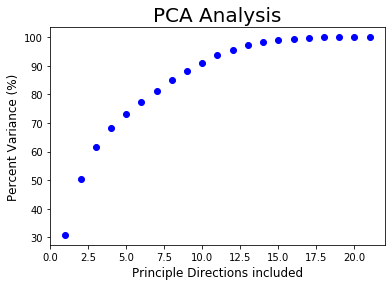

In [303]:
import matplotlib.pyplot as plt
num_cols = x_train.shape[1]
from sklearn.decomposition import PCA
pca = PCA(n_components = num_cols)
pca.fit(x_train)


# Plot the increased 
variances = pca.explained_variance_ratio_
variances = variances * 100
for i in range(1 , len(variances)):
    variances[i] = variances[i-1] + variances[i] 
num_pv = np.arange(1 , len(variances) + 1)
plt.ylabel('Percent Variance (%)' , fontsize = 12)
plt.xlabel('Principle Directions included'  , fontsize=12)
plt.title("PCA Analysis" , fontsize=20)
plt.plot(num_pv,  variances, 'bo')

In [304]:
print(" With 16 principle directions , " , variances[15])

 With 16 principle directions ,  99.49475878287689


While 16 principle directions accounts for 99.5 % of the data's variance, this would only lead to a reduction of five features. I am not convinced this would save sufficient computational effort.

# Linear (Kernel) (Ridge) Regression 
in this section, we will assume there exists a linear relationship y = wx. We want to optimize. <dir> First, lets create a correlation matrix and see what linear relationships exist

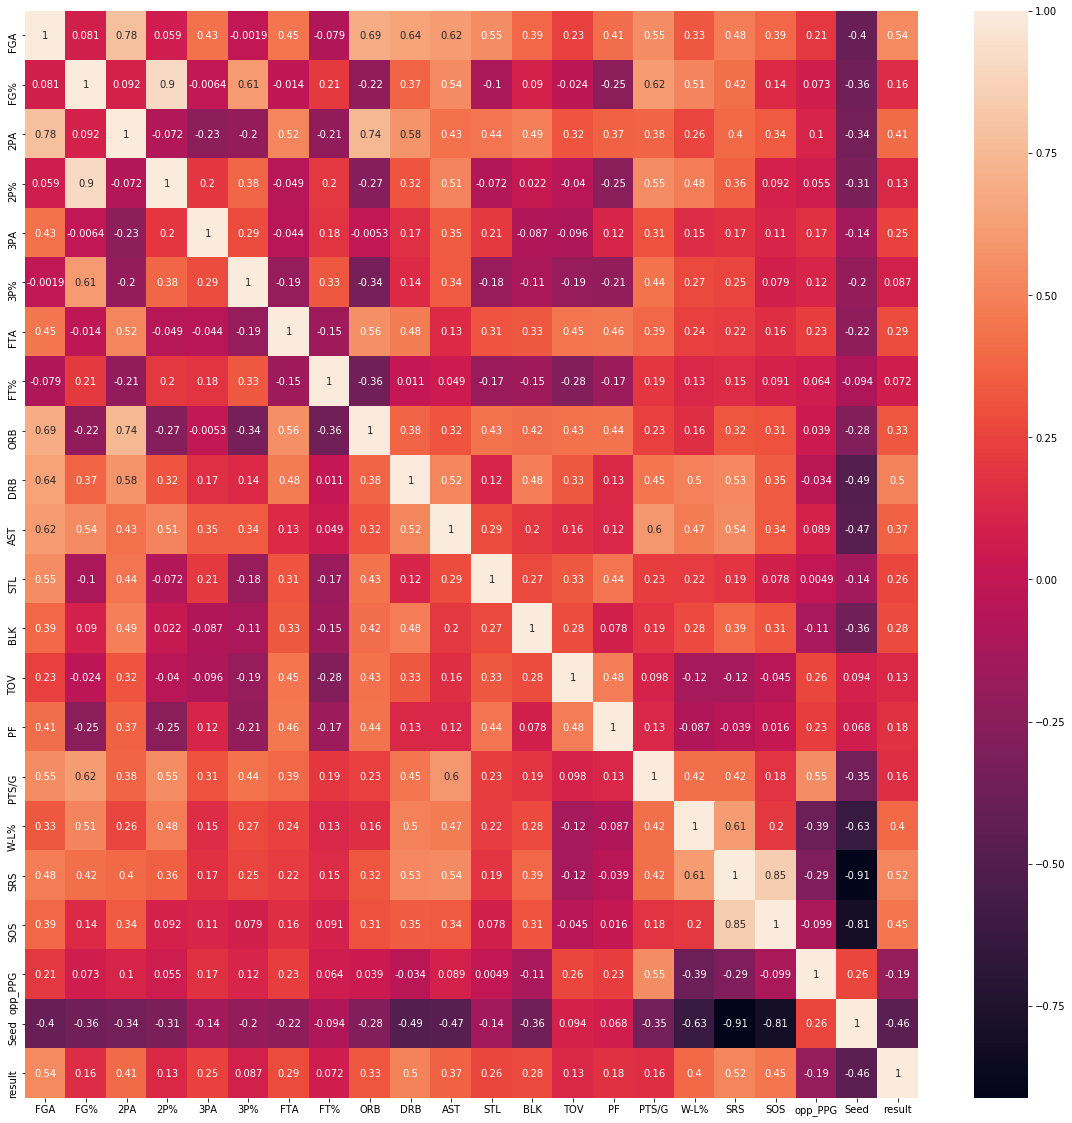

In [305]:
import seaborn as sns
plt.figure(figsize=(20,20))
corr=data_matrix.corr()
ax=sns.heatmap(corr,annot=True)

Some notable results: <dir>
    * defensive rebounds are more correlated with wins than offensive rebounds
    * almost no correlation between FT% and Wins in NCAA tournament!
    * low correlation between 3P% and 3PA 
        + Perhaps this is something that can be accounted for.
        + Feature engineering could be useful - see what percentage of shots were 3P 

In [306]:
# This will be the Ridge Regression
class Ridge_classifier():
    def __init__(self, alpha = 1):
        from sklearn.linear_model import RidgeClassifier
        self.alpha = alpha
        self.model = RidgeClassifier(self.alpha)
        
    def optimize_alpha(self, x_tain , y_train , x_test, y_test):
        '''
        This method takes in the training data and optimizes the alpha parameter
            args:
                x_train - training feature vectors
                y_train - the ground truth results
                x_test  - The testing feature vectors
                y_test  - The testing ground truth
            output:
                Updates our model for the ideal alpha  
        '''
        pass
        
    
    
    def train(self , x_tain , y_train):
        '''
        This method takes in the training data and fits the ridge classifier
            args:
                x_train - training feature vectors
                y_train - the ground truth results
            output:
                No output      
        '''
        self.model.fit(x_train , y_train)
        
    def get_accuracy(self , x , y):
        '''
        This method takes in the training data and fits the ridge classifier
            args:
                x -  feature vectors
                y -  ground truth 

            output:
                 the model's accuracy on input data  
        '''
        return self.model.score(x , y)
    def predict(self, data):
        ''' 
        This method takes in the dataset and returns predictions
            args:
                data - This needs to be of the same dimensionality as the feature vectors in the training set
            output:
                predictions - This are the predicted classifications
        ''' 
        return self.model.predict(data) 
        
        



rc = Ridge_classifier(4)
rc.train(x_train, y_train)
print("The training accuracy is " ,rc.get_accuracy(x_train, y_train) )
print("The testing accuracy is " , rc.get_accuracy(x_test , y_test) )


The training accuracy is  0.879472693032015
The testing accuracy is  0.849624060150376


Polynomial and RBF kernels were applied to the classifier. Neither improved the model. 

# Decision Tree Classifier

#### Hyperparameters
* https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
* Rafael Gomes Mantovani, Tomáš Horváth, Ricardo Cerri, Sylvio Barbon Junior, Joaquin Vanschoren, André Carlos Ponce de Leon Ferreira de Carvalho, “An empirical study on hyperparameter tuning of decision trees” arXiv:1812.02207 " 
* Maybe we should use a random forest instead of a decision tree classifier.

In [307]:
# put the hyperparameters we will tune here
depth = 13     # 13 is the default
mss = 20       # best range for CART = 1 - 40
msl = 15       # best range for CART = 1-20


In [308]:
# This will be the Ridge Regression
class Decision_tree_classifier():
    def __init__(self, max_depth = None , min_samples_split = 2 , min_samples_leaf = 1):
        from sklearn.tree import DecisionTreeClassifier
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.model = DecisionTreeClassifier(max_depth = self.max_depth , min_samples_split = self.min_samples_split , min_samples_leaf = self.min_samples_leaf)


    
    def train(self , x_tain , y_train):
        '''
        This method takes in the training data and fits the ridge classifier
            args:
                x_train - training feature vectors
                y_train - the ground truth results
            output:
                No output      
        '''
        self.model.fit(x_train , y_train)
        
    def get_accuracy(self , x , y):
        '''
        This method takes in the training data and fits the ridge classifier
            args:
                x -  feature vectors
                y -  ground truth 

            output:
                 the model's accuracy on input data  
        '''
        return self.model.score(x , y)
    def predict(self, data):
        ''' 
        This method takes in the dataset and returns predictions
            args:
                data - This needs to be of the same dimensionality as the feature vectors in the training set
            output:
                predictions - This are the predicted classifications
        ''' 
        return self.model.predict(data) 
        
        
# Try it out
dtc = Decision_tree_classifier(5 , 2, 10)
dtc.train(x_train, y_train)
print("The training accuracy is " ,dtc.get_accuracy(x_train, y_train) )
print("The testing accuracy is " , dtc.get_accuracy(x_test , y_test) )


The training accuracy is  0.8493408662900188
The testing accuracy is  0.8045112781954887


# Nueral Net

This is adapted from the TF example https://www.tensorflow.org/tutorials/keras/classification

Right now this is a shallow nueral net (one hidden layer). <dir> 
  * this [post](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) seems to be very usefuel for information on shallow nueral nets.
  * Looking into CNN's could be more useful

In [309]:
from tensorflow import keras
nueral_net_data = data_matrix.copy()

### Build the Nueral Net

In [310]:

input_shape = (21,)  # The shape of the data. This cannot be changed.
num_categories = 2 # The number of labelled categories in our classification scheme. This cannot be changed.
hidden_units_list = [16, 64, 256 , 11]

# These are our layers
num_hidden_units = 8
activation_list = ['sigmoid', 'relu', 'tanh'] # Different options of activation function
activation = activation_list[1]

nueral_net = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(num_hidden_units, activation=activation),
    keras.layers.Dropout(.1) , 
    keras.layers.Dense(num_hidden_units, activation=activation),
    keras.layers.Dense(num_categories, activation='softmax')
])

print(f"The model is built using {num_hidden_units} hidden units and a {activation} activation function")



The model is built using 8 hidden units and a relu activation function


In [344]:
class MLP():
    '''
    This is a simple Multi Layer Perceptron:
       * Linear Fully connected with ReLU activation
    '''
    
    def __init__(self , input_shape , num_categories , num_hidden_units , num_layers , num_epochs, activation = 'ReLU'):
        self.input_shape = input_shape
        self.num_categories = num_categories
        self.num_hidden_units = num_hidden_units
        self.num_layers = num_layers
        self.activation = activation
        self.num_epochs = num_epochs
        self.model = None                   # we need to build the nueral net
        
    def build_network(self):
        nueral_net = keras.Sequential([
            keras.layers.Flatten(input_shape=input_shape),
            keras.layers.Dense(num_hidden_units, activation=activation),
            keras.layers.Dense(num_hidden_units, activation=activation),
            keras.layers.Dense(num_categories, activation='softmax')
        ])

        print(f"The model is built using {num_hidden_units} hidden units and a {activation} activation function")

        self.model = nueral_net
    
    def train(self , x_train , y_train):
        '''
        This method takes in the training data and fits the ridge classifier
            args:
                x_train - training feature vectors
                y_train - the ground truth results
            output:
                No output      
        '''
        # compile the model
            # adam, an adaptive gradient optimizer, helps get out of local optima
        self.model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        # train the model 
        self.model.fit(x_train, y_train, epochs=self.num_epochs)
    
    def get_accuracy(self , x , y):
        '''
        This method takes in the training data and fits the ridge classifier
            args:
                x -  feature vectors
                y -  ground truth 

            output:
                 the model's accuracy on input data  
        '''

        
        test_loss, test_acc = self.model.evaluate(x,  y, verbose=2)
        return test_acc
        
    def predict(self, data):
        ''' 
        This method takes in the dataset and returns predictions
            args:
                data - This needs to be of the same dimensionality as the feature vectors in the training set
            output:
                predictions - This are the predicted classifications
        ''' 
        return self.model.predict_classes(data) 
  

        
# Try it out
mlp = MLP(21 , 2 , 16 , 1 , 10)
mlp.build_network()
mlp.train(x_train, y_train)
print("The testing accuracy is " , mlp.get_accuracy(x_train , y_train) )
print("The testing accuracy is " , mlp.get_accuracy(x_test , y_test) )

The model is built using 8 hidden units and a relu activation function
Train on 531 samples
Epoch 1/10
531/531 [==============================] - 0s 441us/sample - loss: 0.7352 - accuracy: 0.4294
Epoch 2/10
531/531 [==============================] - 0s 43us/sample - loss: 0.6887 - accuracy: 0.5028
Epoch 3/10
531/531 [==============================] - 0s 43us/sample - loss: 0.6524 - accuracy: 0.6026
Epoch 4/10
531/531 [==============================] - 0s 39us/sample - loss: 0.6240 - accuracy: 0.7043
Epoch 5/10
531/531 [==============================] - 0s 41us/sample - loss: 0.6005 - accuracy: 0.7627
Epoch 6/10
531/531 [==============================] - 0s 41us/sample - loss: 0.5788 - accuracy: 0.7815
Epoch 7/10
531/531 [==============================] - 0s 37us/sample - loss: 0.5609 - accuracy: 0.7928
Epoch 8/10
531/531 [==============================] - 0s 36us/sample - loss: 0.5462 - accuracy: 0.8023
Epoch 9/10
531/531 [==============================] - 0s 42us/sample - loss: 0.5330

# Run the tournament

In [345]:
# Recall, we stored the dictionary of teams in the tournament in  "ncaa_framework"
%store -r ncaa_teams

In [346]:


## build the tournament

class tournament():
    
   
    def __init__(self , teams , model ):
        self.origional = teams
        self.teams = copy.deepcopy(teams)               # this needs to be a list of dictionary's south , west, midwest , east, teams in seed order
        self.games = {}
        self.rounds = []
        self.round_32 = []
        self.round_16 = []
        self.round_8 = []
        self.final_four = [ 0 , 0 , 0 , 0]
        self.finals = None
        self.champion = None
        self.model = model
         
    # this method will play the entire tournament by alternating playing make_games and play_round
    def play_tournament(self):
        while self.champion == None:
            self.make_games()
            self.play_round()

    # this method resets the tournament, but uses the origional set of teams.
    def reset(self):
        self.teams = self.origional
        self.games = {}
        self.rounds = []
        self.round_32 = []
        self.round_16 = []
        self.round_8 = []
        self.final_four = [ 0 , 0 , 0 , 0]
        self.finals = None
        self.champion = None
        self.model = model
        
        
    # this method builds the next round of games using the results of the play_round() method
    def make_games(self):
        # this makes all the games for each region - if only one team left: it will return no games
        for region in self.teams:
            reg_teams = self.teams[region] # this get's the teams and puts them into a list
            games = []
            for i in range(len(reg_teams) // 2):
                games += [game(reg_teams[i] , reg_teams[(i + 1) * -1]  , model = self.model , team_data = tournament_stats)]
            self.games[region] = games

    # The following method will play a single round of the tournamnet
    # it is important to note that it considers the final four, and championship as one round
    # At the conclusion, it sets the self.teams to be just the winners. keeping track of each
    # round in self.rounds
    # the final four / finals round returns self.champion as the overall winner
    def play_round(self):
        
        games_played = []
        counter = 0        
        for region in self.games:
            l_games = list(self.games[region])
            l_teams = list(self.teams[region])
            if len(l_teams) != 1:
                winners = []
                
                for g in l_games:
                    g.play_model()
                    #game.print_results
                    winners += [g.winner]
                    games_played += [g]
                # update the teams in the tournament
                self.teams[region] = winners

            else:
                # make the final four
                self.final_four[counter] = self.teams[region][0]
                # play the final four  # this needs to be the correct pairing
                        # update the counter
            counter += 1
        # update the rounds
        if games_played != []:
            self.rounds += [games_played] 
        if self.final_four[0] != 0:
            game1 = game(self.final_four[0] , self.final_four[1], model = self.model , team_data = tournament_stats)
            game1.play_model()
            game2 = game(self.final_four[2] , self.final_four[3], model = self.model , team_data = tournament_stats)
            game2.play_model()
            
            # put winners in finals 
            self.finals = [game1.winner , game2.winner]
                
            self.rounds += [ [game1 , game2] ]
                
            # play the final
            final_game = game(self.finals[0] , self.finals[1], model = self.model , team_data = tournament_stats)
                
            final_game.play_model()
            self.champion = final_game.winner
            self.rounds += [[final_game]]


    def short_describe(self):
        final_four = self.rounds[-2]
        finals = self.rounds[-1]
        
        print("In the Final Four,  ")
        for game in final_four:
            game.print_results()
        print("In the finals,  ")
        finals[-1].print_results()
        
    def give_results(self):
        round_count = 1
        for r in self.rounds:
            print("In round " , round_count)
            round_count += 1
            for game in r:
                game.print_results()
            print("   ")
            
              
class game():
    
    def __init__(self, team1 , team2 , model = None , team_data = None):
        self.team_one = team1
        self.team_two = team2
        self.model = model
        self.team_data = team_data
        self.winner = None
        self.loser = None
        

    def print_results(self):
        print(self.winner , " will beat " , self.loser)
        
    # this method plays a game assuming each team has equal chance of winning. 
    def play_even(self):
        choice = np.random.uniform()
        if choice <= 0.5:
            self.winner = self.team_one
            self.loser  = self.team_two
        else:
            self.winner = self.team_two
            self.loser  = self.team_one
            
    def play_model(self):
        model = self.model
        # need to build the feature vector
        s1 = self.team_data[self.team_data["Team"] == self.team_one ]
        s2 = self.team_data[self.team_data["Team"] == self.team_two ]
        s1 = s1.drop(["Team" ] , axis = 1)
        s2 = s2.drop(["Team" ] , axis = 1)
        # need to reset their indices
        s2 = s2.reset_index(drop=True)
        s1 = s1.reset_index(drop=True)   
        # subtract the two stat sets
        feature_vector = s1.sub(s2) 
        # get prediction
        choice = model.predict(feature_vector)   
        if choice == 1:
            self.winner = self.team_one
            self.loser  = self.team_two
        else:
            self.winner = self.team_two
            self.loser  = self.team_one
            

In [353]:
mlp = MLP(21 , 2 , 16 , 1 , 16)
mlp.build_network()
mlp.train(x_train, y_train)
print("The testing accuracy is " , mlp.get_accuracy(x_train , y_train) )
print("The testing accuracy is " , mlp.get_accuracy(x_test , y_test) )

t = tournament(ncaa_teams , mlp)
t.play_tournament()
t.short_describe()
t.give_results()

The model is built using 8 hidden units and a relu activation function
Train on 531 samples
Epoch 1/16
531/531 [==============================] - 0s 439us/sample - loss: 0.8052 - accuracy: 0.4275
Epoch 2/16
531/531 [==============================] - 0s 44us/sample - loss: 0.7787 - accuracy: 0.4557
Epoch 3/16
531/531 [==============================] - 0s 39us/sample - loss: 0.7519 - accuracy: 0.4689
Epoch 4/16
531/531 [==============================] - 0s 40us/sample - loss: 0.7250 - accuracy: 0.4821
Epoch 5/16
531/531 [==============================] - 0s 37us/sample - loss: 0.6991 - accuracy: 0.4878
Epoch 6/16
531/531 [==============================] - 0s 38us/sample - loss: 0.6781 - accuracy: 0.5066
Epoch 7/16
531/531 [==============================] - 0s 39us/sample - loss: 0.6577 - accuracy: 0.5706
Epoch 8/16
531/531 [==============================] - 0s 38us/sample - loss: 0.6388 - accuracy: 0.6554
Epoch 9/16
531/531 [==============================] - 0s 37us/sample - loss: 0.6202